In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import shap

In [33]:
# Load and preprocess
df = pd.read_csv('telco_train.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churned
0,4950-BDEUX,Male,0,No,No,35,No,No phone service,DSL,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,0
1,7993-NQLJE,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,0
2,7321-ZNSLA,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,...,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,0
3,4922-CVPDX,Female,0,Yes,No,26,Yes,No,DSL,No,...,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7,0
4,2903-YYTBW,Male,0,Yes,Yes,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,6308-CQRBU,Female,0,Yes,No,71,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,No,Electronic check,109.25,7707.7,0
5630,2842-JTCCU,Male,0,No,No,2,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Bank transfer (automatic),46.05,80.35,1
5631,6402-ZFPPI,Female,1,No,No,25,Yes,Yes,Fiber optic,Yes,...,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,102.80,2660.2,1
5632,3594-BDSOA,Female,0,Yes,No,24,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),20.40,482.8,0


In [34]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df.drop(['customerID'], axis=1, inplace=True)
df['churned'] = df['churned'].astype(int)
df.reset_index(drop=True, inplace=True)


churned
0    0.734269
1    0.265731
Name: proportion, dtype: float64


<Axes: xlabel='churned', ylabel='count'>

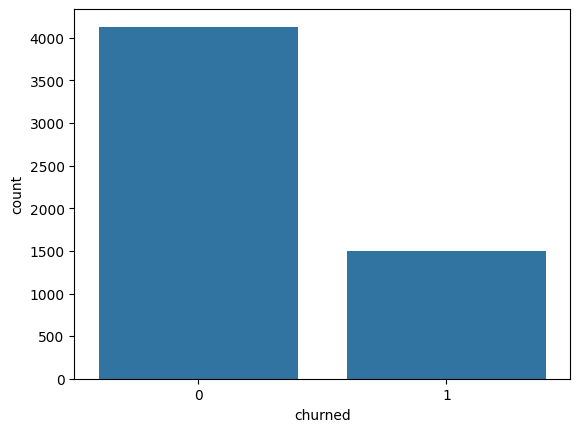

In [35]:
print(df['churned'].value_counts(normalize=True))
sns.countplot(data=df, x='churned')

In [36]:
cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df.drop('churned', axis=1)
y = df['churned']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [39]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  print(f"\n--- {name} ---")
  print(classification_report(y_test, preds))


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       827
           1       0.64      0.52      0.57       299

    accuracy                           0.79      1126
   macro avg       0.74      0.71      0.72      1126
weighted avg       0.79      0.79      0.79      1126


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       827
           1       0.66      0.58      0.62       299

    accuracy                           0.81      1126
   macro avg       0.76      0.73      0.74      1126
weighted avg       0.80      0.81      0.80      1126



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:02:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       827
           1       0.62      0.51      0.56       299

    accuracy                           0.79      1126
   macro avg       0.73      0.70      0.71      1126
weighted avg       0.78      0.79      0.78      1126



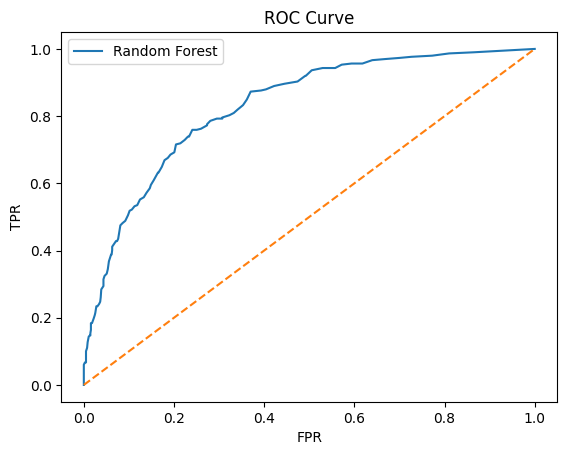

In [40]:
rf = models['Random Forest']
probs = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

In [43]:
joblib.dump(rf, 'model.pkl')

['model.pkl']

In [44]:
joblib.dump(X.columns.tolist(), 'columns.pkl')


['columns.pkl']